# TRABALHO 6 - Homografia e RANSAC

#### 1. Extraindo pontos e descritores SIFT

Em visão computacional, a detecção e descrição de features robustas é fundamental para inúmeras aplicações, como correspondência de imagens, reconstrução 3D e navegação robótica. O algoritmo SIFT (Scale-Invariant Feature Transform) é uma técnica amplamente utilizada para extração de pontos de interesse e criação de descritores que sejam invariantes a mudanças de escala, rotação e, em certo grau, à iluminação.

Para estimar uma homografia entre duas imagens, o primeiro passo é detectar pontos de interesse em ambas. Esses pontos correspondem a características distintas na imagem, que podem ser utilizados para estabelecer correspondências confiáveis entre os dois conjuntos de dados. Para executar o trabalho, utilizei duas fotos de diferentes ângulos de uma mesma capa de livro, como pode ser visto abaixo.

In [2]:
# Importação de bibliotecas
import matplotlib.pyplot as plt 
import random
import numpy as np
import cv2

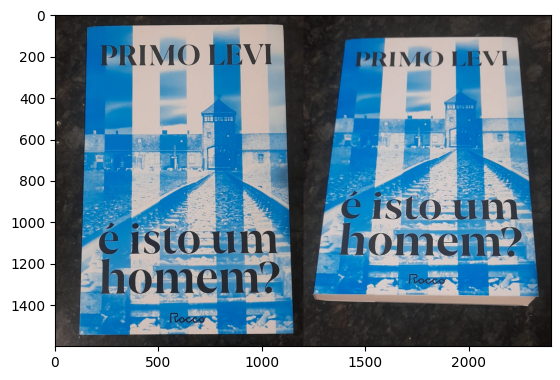

In [3]:
# Leitura das imagens
img1 = cv2.imread('/home/ramon/projects/visao/images/book1.jpeg')
img2 = cv2.imread('/home/ramon/projects/visao/images/book2.jpeg')

# Conversão para escala de cinza
gray1 = cv2.cvtColor(img1, cv2.COLOR_BGR2GRAY)
gray2 = cv2.cvtColor(img2, cv2.COLOR_BGR2GRAY)

# Concatenação das imagens
concatenatedImg = cv2.cvtColor(cv2.hconcat([img1, img2]), cv2.COLOR_BGR2RGB)

# Exibição das imagens
plt.imshow(concatenatedImg)
plt.show()

A biblioteca OpenCV implementa o algoritmo para identificação de pontos SIFT. O primeiro passo é inicializar o detector de features com o método cv2.SIFT_create(). Em seguida, a função detectAndCompute() é utilizada para identificar os pontos de interesse e calcular os descritores associados. Ao chamar sift.detectAndCompute(gray1, None), o algoritmo processa a imagem em escala de cinza gray1, detecta os pontos de interesse e retorna suas localizações e orientações em keyPoints1, além de gerar os descritores correspondentes em descriptors1. O mesmo processo é aplicado à segunda imagem (gray2).

In [4]:
# Criação do detector SIFT
sift = cv2.SIFT_create()

# Detecção dos pontos de interesse e descritores
keyPoints1, descriptors1 = sift.detectAndCompute(gray1, None)
keyPoints2, descriptors2 = sift.detectAndCompute(gray2, None)

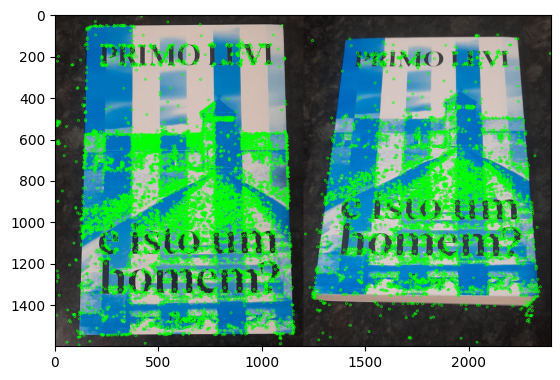

In [5]:
# Cria cópias das duas imagens para desenhar os pontos SIFT
img1_keypoints = img1.copy()
img2_keypoints = img2.copy()

# Desenha os pontos SIFT na imagem1
for kp in keyPoints1:
    x, y = int(kp.pt[0]), int(kp.pt[1]) 
    cv2.circle(img1_keypoints, (x, y), radius=5, color=(0, 255, 0), thickness=2)

# Desenha os pontos SIFT na imagem2
for kp in keyPoints2:
    x, y = int(kp.pt[0]), int(kp.pt[1]) 
    cv2.circle(img2_keypoints, (x, y), radius=5, color=(0, 255, 0), thickness=2)

# Concatenação das imagens com os pontos SIFT
concatenatedImgKp = cv2.cvtColor(cv2.hconcat([img1_keypoints, img2_keypoints]), cv2.COLOR_BGR2RGB)

# Exibição das imagens com os pontos SIFT
plt.imshow(concatenatedImgKp, cmap='gray')
plt.show()

Para encontrar correspondências entre os descritores, utilizou-se o FLANN (Fast Library for Approximate Nearest Neighbors), uma biblioteca para busca de vizinhos aproximados. O algoritmo de busca é o KD-Tree e o número de verificações durante a busca é 50. Para refinar as correspondências, é aplicado o Lowe's Ratio Test, que seleciona apenas as correspondências em que a razão entre as distâncias do primeiro e segundo vizinhos seja menor que 0.75.

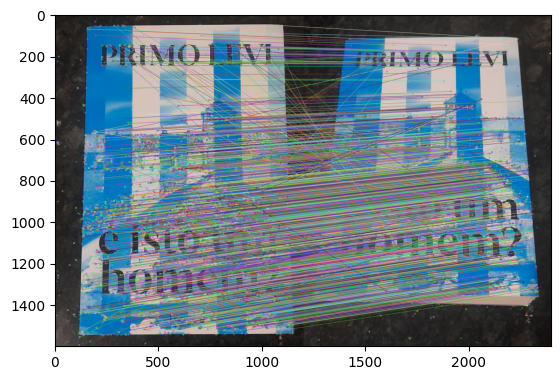

In [32]:
# Configuração do FLANN 
index_params = dict(algorithm=1, trees=5) 
search_params = dict(checks=50)

# Inicializa o FLANN matcher
flann = cv2.FlannBasedMatcher(index_params, search_params)

# Encontra as correspondências entre os descritores das duas imagens
matches = flann.knnMatch(descriptors1, descriptors2, k=2)

# Filtra as correspondências
good_matches = []
for m, n in matches:
    if m.distance < 0.75 * n.distance:  
        good_matches.append(m)

# Desenha as correspondências na imagem
result_img = cv2.drawMatches(img1, keyPoints1, img2, keyPoints2, good_matches, None, flags=cv2.DrawMatchesFlags_DEFAULT)

# Exibição da imagem com correspondências
plt.imshow(cv2.cvtColor(result_img, cv2.COLOR_BGR2RGB))
plt.show()

A função abaixo implementa o cálculo da matriz de homografia, a partir de correspondências entre dois conjuntos de pontos. Os pontos da imagem de origem (org_pts) e de destino (dst_pts) são utilizados para montar a matriz A, que representa o sistema de equações A⋅h = 0, onde h é o vetor que contém os elementos da matriz de homografia. Para resolver o sistema de equações, é utilizado o método numérico SVD (Singular Value Decomposition), que decompõe a matriz A em duas outras matrizes, U e V. Os valores da matriz 𝐻 estão no último vetor coluna da matriz V.

In [7]:
def homography(org_pts, dst_pts):
    # Monta a matriz A (Ax = 0)
    A = []
    for i in range(len(org_pts)):
        x, y = org_pts[i]
        xp, yp = dst_pts[i]
        A.append([-x, -y, -1, 0, 0, 0, x * xp, y * xp, xp])
        A.append([0, 0, 0, -x, -y, -1, x * yp, y * yp, yp])
    A = np.array(A)

    # Calcula a matriz de homografia usando SVD
    _, _, V = np.linalg.svd(A)
    H = V[-1].reshape(3, 3)
    return H / H[2, 2]  

A função dist_euclidian(H, pt1, pt2), implementada abaixo, é utilizada para calcular a distância euclidiana entre um ponto projetado e seu ponto correspondente, a fim de avaliar a qualidade da transformação realizada pela matriz de homografia.

In [8]:
def dist_euclidian(H, pt1, pt2):
    # Coloca os pontos em coordenadas homogêneas
    pt1 = np.array([pt1[0], pt1[1], 1])
    pt2 = np.array([pt2[0], pt2[1], 1])
    pt2_ = np.dot(H, pt1)
    # Obtém as coordenadas cartesianas do ponto projetado
    pt2_ = pt2_ / pt2_[2]
    # Calcula e retorna a distância entre os pontos
    return np.linalg.norm(pt2 - pt2_)

Para verificar se as correnspondências entre os pontos são satisfatórias, implementei o algoritmo RANSAC (Random Sample Consensus) para estimar a matriz de homografia. Inicialmente, o número total de pontos correspondentes (n_points) é determinado, e o processo de iteração é repetido N vezes. Em cada iteração:

1. Quatro pares de pontos são selecionados aleatoriamente a partir dos conjuntos org_pts e dst_pts (par de correspondências).
2. A matriz de homografia é calculada para esses quatro pares utilizando a função homography.
3. Para cada ponto, é calculada a distância de homografia, verificando o erro da transformação.
4. Os pontos que têm uma distância menor que o limite (threshold) são classificados como inliers.

Se o número de inliers ultrapassar o limiar T, uma nova matriz de homografia é recalculada usando os inliers encontrados, e o processo é encerrado. Caso contrário, o melhor conjunto de inliers e a matriz de homografia associada são atualizados sempre que um conjunto com mais inliers é encontrado.

Após todas as iterações, a matriz de homografia final H é recalculada com base no melhor conjunto de inliers. O algoritmo retorna H e o conjunto de inliers.

In [9]:
def ransac(org_pts, dst_pts, threshold, N, T):
    best_H = None
    best_inliers = []
    n_points = len(org_pts)

    for _ in range(N):
        # Seleciona aleatoriamente 4 pares de pontos
        indices = random.sample(range(n_points), 4)
        pts1 = [org_pts[i] for i in indices]
        pts2 = [dst_pts[i] for i in indices]

        # Calcula a matriz de homografia
        H = homography(pts1, pts2)

        # Calcula os inliers
        inliers = []
        for i in range(n_points):
            # Calcula a distância de homografia
            distance_homography = dist_euclidian(H, org_pts[i], dst_pts[i])**2 + dist_euclidian(np.linalg.inv(H), dst_pts[i], org_pts[i])**2
            if distance_homography < threshold:
                inliers.append(i)

        # Se o número de inliers for maior que o limiar T, calcula uma nova a matriz de homografia 
        if len(inliers) > T:
            best_H = homography([org_pts[i] for i in inliers], [dst_pts[i] for i in inliers])
            best_inliers = inliers
            return best_H, best_inliers
        # Atualiza o melhor conjunto de inliers
        elif len(inliers) > len(best_inliers):
            best_H = H
            best_inliers = inliers
    
    # Depois de N iterações, calcula uma nova a matriz de homografia com o melhor conjunto de inliers
    best_H = homography([org_pts[i] for i in inliers], [dst_pts[i] for i in inliers])
    best_inliers = inliers

    return best_H, best_inliers

In [10]:
# Converte os pontos de correspondência para o formato do numpy
pts_img1 = np.float32([keyPoints1[m.queryIdx].pt for m in good_matches]).reshape(-1, 2)
pts_img2 = np.float32([keyPoints2[m.trainIdx].pt for m in good_matches]).reshape(-1, 2)

Para o threshold, escolhi um valor intermediário entre 2 e 4 pixels. Para N, chutando um número de outliers de 30%, encontrei na tabela o valor 17. Para T, apenas multipliquei o número de correspondências pela proporção de inliers.

In [60]:
# Calcula a matriz de homografia usando RANSAC
ransac_H, ransac_inliers = ransac(pts_img1, pts_img2, threshold=3, N=17, T=0.7*len(good_matches))

In [61]:
# Desenha os inliers e outliers estimados pelo RANSAC
def draw_matches(img1, img2, kp1, kp2, matches, inliers):
    # Combina as imagens lado a lado
    height1, width1 = img1.shape[:2]
    height2, width2 = img2.shape[:2]
    combined_img_inliers = np.zeros((max(height1, height2), width1 + width2, 3), dtype=np.uint8)
    combined_img_outliers = np.zeros((max(height1, height2), width1 + width2, 3), dtype=np.uint8)
    combined_img_inliers[:height1, :width1] = img1
    combined_img_inliers[:height2, width1:] = img2
    combined_img_outliers[:height1, :width1] = img1
    combined_img_outliers[:height2, width1:] = img2

    # Desenha inliers em verde
    for i in inliers:
        match = matches[i]
        pt1 = tuple(np.int32(kp1[match.queryIdx].pt))
        pt2 = tuple(np.int32(kp2[match.trainIdx].pt))
        pt2 = (pt2[0] + width1, pt2[1])  # Ajusta para a segunda imagem

        color = (0, 255, 0)  # Verde
        cv2.line(combined_img_inliers, pt1, pt2, color, 1)
        cv2.circle(combined_img_inliers, pt1, 5, color, -1)
        cv2.circle(combined_img_inliers, pt2, 5, color, -1)

    # Desenha outliers em vermelho
    for i, match in enumerate(matches):
        if i not in inliers:
            pt1 = tuple(np.int32(kp1[match.queryIdx].pt))
            pt2 = tuple(np.int32(kp2[match.trainIdx].pt))
            pt2 = (pt2[0] + width1, pt2[1])  # Ajusta para a segunda imagem

            color = (0, 0, 255)  # Vermelho
            cv2.line(combined_img_outliers, pt1, pt2, color, 1)
            cv2.circle(combined_img_outliers, pt1, 5, color, -1)
            cv2.circle(combined_img_outliers, pt2, 5, color, -1)

    return combined_img_inliers, combined_img_outliers

In [62]:
# Obtém as imagens com inliers e outliers
inliers_img, outliers_img = draw_matches(img1, img2, keyPoints1, keyPoints2, good_matches, ransac_inliers)

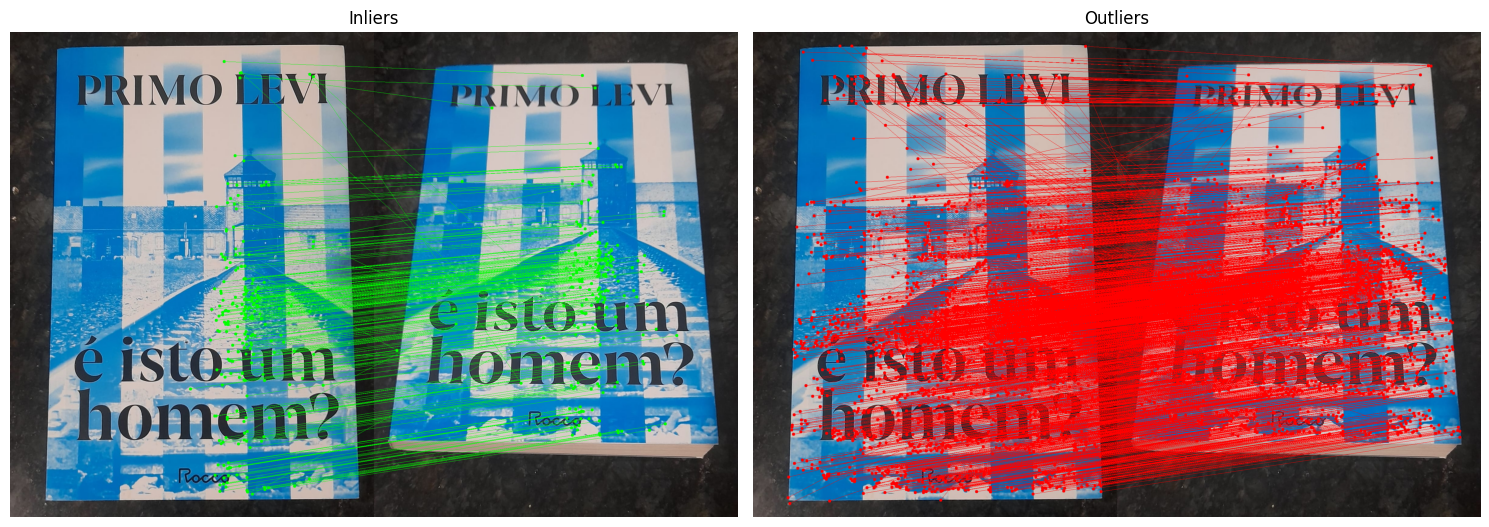

In [63]:
# Exibe as imagens com inliers e outliers
fig, axes = plt.subplots(1, 2, figsize=(15, 7))

axes[0].imshow(cv2.cvtColor(inliers_img, cv2.COLOR_BGR2RGB))
axes[0].set_title("Inliers")
axes[0].axis("off")

axes[1].imshow(cv2.cvtColor(outliers_img, cv2.COLOR_BGR2RGB))
axes[1].set_title("Outliers")
axes[1].axis("off")

plt.tight_layout()
plt.show()